Классификация изображений CIFAR-10

**Цель работы:** Создать, обучить и оценить сверточную нейронную сеть (CNN) для задачи классификации изображений из набора данных CIFAR-10 с использованием фреймворка PyTorch.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## 2. Конфигурация среды и гиперпараметров

Определяем ключевые параметры, которые будут использоваться для обучения модели.

In [2]:
processing_unit = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Вычисления будут производиться на: {processing_unit}')

Вычисления будут производиться на: cuda


In [3]:
NUM_EPOCHS = 10      
BATCH_SIZE = 128     #
LEARNING_RATE = 0.001 

## 3. Подготовка данных (Dataset & DataLoader)

Загружаем набор данных CIFAR-10. Для обучающей выборки применяем аугментацию, чтобы повысить обобщающую способность модели. Для тестовой выборки используем только базовые преобразования.

In [4]:
training_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),     
    transforms.RandomHorizontalFlip(),         
    transforms.ToTensor(),                     
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), 
])

validation_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [5]:
cifar10_training_data = torchvision.datasets.CIFAR10(root='./cifar_data', train=True, download=True, transform=training_transforms)
cifar10_testing_data = torchvision.datasets.CIFAR10(root='./cifar_data', train=False, download=True, transform=validation_transforms)

train_loader = torch.utils.data.DataLoader(cifar10_training_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(cifar10_testing_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

cifar_classes = ('самолет', 'автомобиль', 'птица', 'кот', 'олень',
                 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик')

print('Подготовка данных успешно завершена.')

100%|██████████| 170M/170M [00:09<00:00, 18.3MB/s] 


Extracting ./cifar_data\cifar-10-python.tar.gz to ./cifar_data
Files already downloaded and verified
Подготовка данных успешно завершена.


### Визуализация примеров данных

Убедимся, что данные загружены корректно, и посмотрим на несколько случайных изображений из обучающей выборки.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.82809].


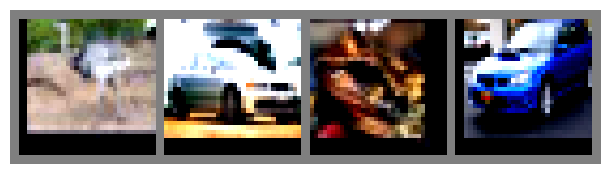

Истинные метки:  птица      автомобиль лягушка    автомобиль


In [6]:
def show_image_grid(image_tensor):
    """Функция для отображения сетки изображений."""
    image_tensor = image_tensor / 2 + 0.5     # Де-нормализация
    numpy_image = image_tensor.numpy()
    plt.figure(figsize=(10, 2))
    plt.imshow(np.transpose(numpy_image, (1, 2, 0)))
    plt.axis('off')
    plt.show()

# Получаем один батч для демонстрации
image_batch_iterator = iter(train_loader)
sample_images, sample_labels = next(image_batch_iterator)

show_image_grid(torchvision.utils.make_grid(sample_images[:4]))
print('Истинные метки: ', ' '.join(f'{cifar_classes[sample_labels[j]]:10s}' for j in range(4)))

## 4. Определение архитектуры модели

Создаем класс для сверточной нейронной сети. Архитектура будет состоять из нескольких сверточных блоков и полносвязного классификатора на выходе.

In [7]:
class ImageClassifierVGGStyle(nn.Module):
    def __init__(self, num_classes=10):
        super(ImageClassifierVGGStyle, self).__init__()

        # Блок 1: два сверточных слоя и max-pooling
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Блок 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Блок 3
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Полносвязный классификатор с Dropout для регуляризации
        self.fully_connected_classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 4 * 4, 1024), # Размер после 3-х пулингов 32x32 -> 4x4
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, num_classes)
        )

    def forward(self, input_tensor):
        # Прогон через сверточные блоки
        features = self.conv_block1(input_tensor)
        features = self.conv_block2(features)
        features = self.conv_block3(features)
        # "Выпрямление" карты признаков в вектор
        features = features.view(features.size(0), -1)
        # Прогон через классификатор
        output = self.fully_connected_classifier(features)
        return output

In [8]:
# Создаем экземпляр модели и перемещаем его на выбранное устройство
model = ImageClassifierVGGStyle(num_classes=10).to(processing_unit)

print("===== Архитектура Нейронной Сети =====")
print(model)

===== Архитектура Нейронной Сети =====
ImageClassifierVGGStyle(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d

## 5. Обучение модели

Определяем функцию потерь и оптимизатор. Затем запускаем цикл обучения на заданное количество эпох.

In [9]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [10]:
print("Начинаем процесс обучения модели...")
training_loss_history = []
num_batches = len(train_loader)

for epoch in range(NUM_EPOCHS):
    model.train() # Переводим модель в режим обучения
    running_loss = 0.0
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        # Перемещаем данные на целевое устройство
        batch_images = batch_images.to(processing_unit)
        batch_labels = batch_labels.to(processing_unit)

        # Шаг 1: Прямой проход (forward pass)
        predictions = model(batch_images)
        loss = criterion(predictions, batch_labels)

        # Шаг 2: Обратное распространение ошибки (backward pass)
        optimizer.zero_grad() # Обнуляем градиенты
        loss.backward()       # Вычисляем градиенты
        optimizer.step()      # Обновляем веса модели

        running_loss += loss.item()

    # Сохраняем и выводим среднюю ошибку за эпоху
    avg_epoch_loss = running_loss / num_batches
    training_loss_history.append(avg_epoch_loss)
    print(f'Эпоха [{epoch+1:02d}/{NUM_EPOCHS}], Средняя ошибка: {avg_epoch_loss:.4f}')

print('Обучение успешно завершено!')

Начинаем процесс обучения модели...
Эпоха [01/10], Средняя ошибка: 1.6026
Эпоха [02/10], Средняя ошибка: 1.1459
Эпоха [03/10], Средняя ошибка: 0.9393
Эпоха [04/10], Средняя ошибка: 0.8241
Эпоха [05/10], Средняя ошибка: 0.7338
Эпоха [06/10], Средняя ошибка: 0.6765
Эпоха [07/10], Средняя ошибка: 0.6177
Эпоха [08/10], Средняя ошибка: 0.5748
Эпоха [09/10], Средняя ошибка: 0.5399
Эпоха [10/10], Средняя ошибка: 0.4985
Обучение успешно завершено!


### График потерь

Визуализируем, как изменялась функция потерь на протяжении всего процесса обучения.

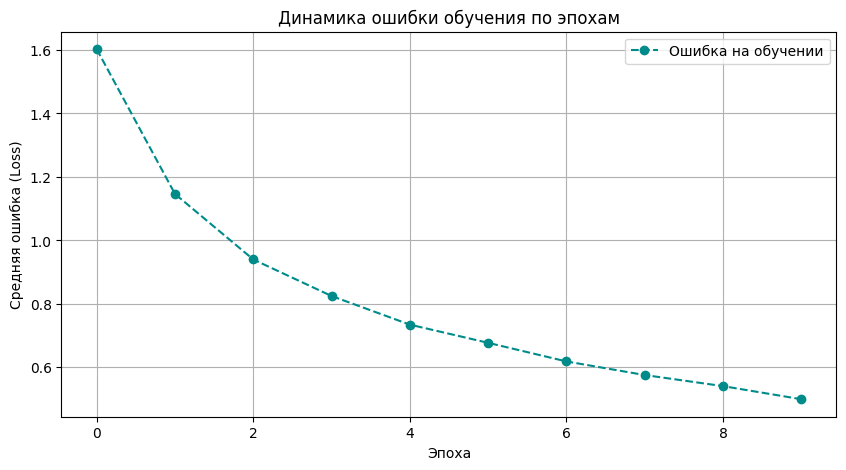

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(training_loss_history, color='darkcyan', linestyle='--', marker='o', label='Ошибка на обучении')
plt.title('Динамика ошибки обучения по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Средняя ошибка (Loss)')
plt.legend()
plt.grid(True)
plt.show()

## 6. Оценка качества модели

Проверяем производительность обученной модели на тестовом наборе данных, который она не видела во время обучения.

In [12]:
model.eval()  # Переключаем модель в режим оценки
with torch.no_grad(): # Отключаем вычисление градиентов для экономии ресурсов
    num_correct = 0
    num_total = 0
    for images, labels in test_loader:
        images = images.to(processing_unit)
        labels = labels.to(processing_unit)
        
        # Получаем предсказания
        outputs = model(images)
        _, predicted_indices = torch.max(outputs.data, 1)
        
        # Считаем статистику
        num_total += labels.size(0)
        num_correct += (predicted_indices == labels).sum().item()

final_accuracy = 100 * num_correct / num_total
print(f'Общая точность на 10,000 тестовых изображений: {final_accuracy:.2f} %')

Общая точность на 10,000 тестовых изображений: 81.80 %


### Точность по каждому классу

Рассчитаем точность для каждого класса в отдельности, чтобы понять, какие объекты модель распознает лучше, а какие — хуже.

In [13]:
class_correct_counts = list(0. for i in range(10))
class_total_counts = list(0. for i in range(10))

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(processing_unit)
        labels = labels.to(processing_unit)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        # Сравнение предсказаний с истинными метками
        correct_mask = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label_id = labels[i]
            class_correct_counts[label_id] += correct_mask[i].item()
            class_total_counts[label_id] += 1

print("Детализация точности по каждому классу:")
for i in range(10):
    if class_total_counts[i] > 0:
        accuracy = 100 * class_correct_counts[i] / class_total_counts[i]
        print(f'  - Точность для класса "{cifar_classes[i]:<10s}": {accuracy:.2f} %')
    else:
        print(f'  - Для класса "{cifar_classes[i]:<10s}" не найдено примеров.')

Детализация точности по каждому классу:
  - Точность для класса "самолет   ": 80.30 %
  - Точность для класса "автомобиль": 95.00 %
  - Точность для класса "птица     ": 66.40 %
  - Точность для класса "кот       ": 55.70 %
  - Точность для класса "олень     ": 86.30 %
  - Точность для класса "собака    ": 76.60 %
  - Точность для класса "лягушка   ": 88.50 %
  - Точность для класса "лошадь    ": 82.60 %
  - Точность для класса "корабль   ": 94.80 %
  - Точность для класса "грузовик  ": 91.80 %


## 7. Визуализация результатов предсказаний

Посмотрим на конкретные примеры из тестовой выборки и сравним предсказания модели с реальными метками.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.71453285..1.8768656].


Примеры работы модели на тестовом наборе:


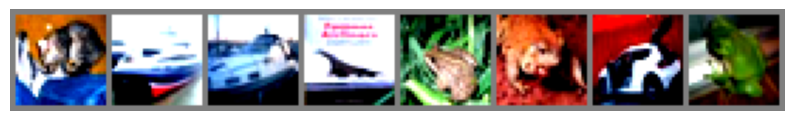

Реальные классы:  кот          корабль      корабль      самолет      лягушка      лягушка      автомобиль   лягушка     
Предсказания:     кот          корабль      корабль      корабль      лягушка      лягушка      автомобиль   лягушка     


In [14]:
# Получаем новый батч из тестовой выборки
data_iterator = iter(test_loader)
test_images, test_labels = next(data_iterator)

# Переводим модель в режим оценки
model.eval()

# Перемещаем данные и делаем предсказания
images_for_prediction = test_images.to(processing_unit)
raw_outputs = model(images_for_prediction)
_, predicted_classes = torch.max(raw_outputs, 1)

# Возвращаем данные на CPU для отрисовки
test_images_cpu = test_images.cpu()
predicted_classes_cpu = predicted_classes.cpu()


num_images_to_show = 8


print("Примеры работы модели на тестовом наборе:")
show_image_grid(torchvision.utils.make_grid(test_images_cpu[:num_images_to_show]))


print('Реальные классы: ', ' '.join(f'{cifar_classes[test_labels[j]]:12s}' for j in range(num_images_to_show)))
print('Предсказания:    ', ' '.join(f'{cifar_classes[predicted_classes_cpu[j]]:12s}' for j in range(num_images_to_show)))